# Natural Processing Languague


```Dataset: EmoEvent ```

EmoEvent es un corpus de tweets en espa√±ol y ingl√©s dise√±ado espec√≠ficamente para la tarea de clasificaci√≥n de emociones en el contexto de eventos de Twitter. A diferencia de conjuntos de datos gen√©ricos, EmoEvent se caracteriza porque cada tweet est√° asociado a un evento particular (ej: "GameOfThrones", "NotreDame", "Venezuela"), lo que a√±ade una capa de complejidad y contexto crucial para el an√°lisis.


**¬øQu√© encontraremos en este dataset?**

El dataset est√° compuesto por 8,409 tweets en espa√±ol, anotados manualmente con dos niveles de informaci√≥n:

***Emoci√≥n Principal (emotion):*** La categor√≠a emocional principal del tweet. El modelo deber√° aprender a predecir una de las siguientes 8 clases:

Ira (anger)

Tristeza (sadness)

Alegr√≠a (joy)

Asco (disgust)

Miedo (fear)

Sorpresa (surprise)

Ofensivo (offensive)

Otros (others) - Para tweets que no expresan una emoci√≥n clara de las anteriores.

***Etiqueta de Ofensividad (offensive):*** Una clasificaci√≥n binaria que indica si el contenido del tweet es considerado ofensivo (OFF) o no ofensivo (NO). Esta etiqueta est√° fuertemente correlacionada con la emoci√≥n de "ira" (anger), pero no es exclusiva de ella.

## 1. Preparaci√≥n del entorno

In [4]:
!pip install transformers torch torchvision torchaudio --quiet
!pip install seaborn --quiet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split # Para evaluaci√≥n

## 2. Carga del dataset

In [5]:
!git clone https://github.com/fmplaza/EmoEvent.git # Descargar del dataset desde GitHub

fatal: destination path 'EmoEvent' already exists and is not an empty directory.


In [6]:
!find EmoEvent -type f -name "*.csv"


EmoEvent/emoevent_es.csv
EmoEvent/emoevent_en.csv


In [7]:
df_train = pd.read_csv("EmoEvent/splits/es/train.tsv", sep="\t")
df_dev   = pd.read_csv("EmoEvent/splits/es/dev.tsv", sep="\t")
df_test  = pd.read_csv("EmoEvent/splits/es/test.tsv", sep="\t")

print("Tama√±o train:", df_train.shape)
print("Tama√±o dev:", df_dev.shape)
print("Tama√±o test:", df_test.shape)

print("\nColumnas disponibles:", df_train.columns.tolist())
df_train.head()

Tama√±o train: (5723, 5)
Tama√±o dev: (844, 5)
Tama√±o test: (1656, 5)

Columnas disponibles: ['id', 'event', 'tweet', 'offensive', 'emotion']


id          event  \
0  a0c1a858-a9b8-4cb1-8a81-1602736ff5b8  GameOfThrones   
1  9b272817-a231-4f68-bdf4-3350d4919330      Venezuela   
2  4bd5b1e5-4b74-440a-82f4-c2567a241011      NotreDame   
3  0bb9d7c9-d781-4684-890e-a94bfb50acc0      NotreDame   
4  88749098-d539-4500-9209-0bbfae2b109c  GameOfThrones   

                                               tweet offensive  emotion  
0  La Gran Guerra de #JuegoDeTronos nos ha dejado...        NO   others  
1  El golpe de Estado en #Venezuela est√° m√°s lejo...        NO   others  
2  No tengo una foto en la catedral de #NotreDame...        NO  sadness  
3  #NotreDame nunca llegue a visitar tan grandios...        NO  sadness  
4      A tomar por culo mi crush üò≠üò≠üò≠üò≠üò≠#JuegoDeTronos       OFF  sadness

/tmp/ipython-input-1662017143.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df_train["emotion"], order=df_train["emotion"].value_counts().index, palette="viridis")


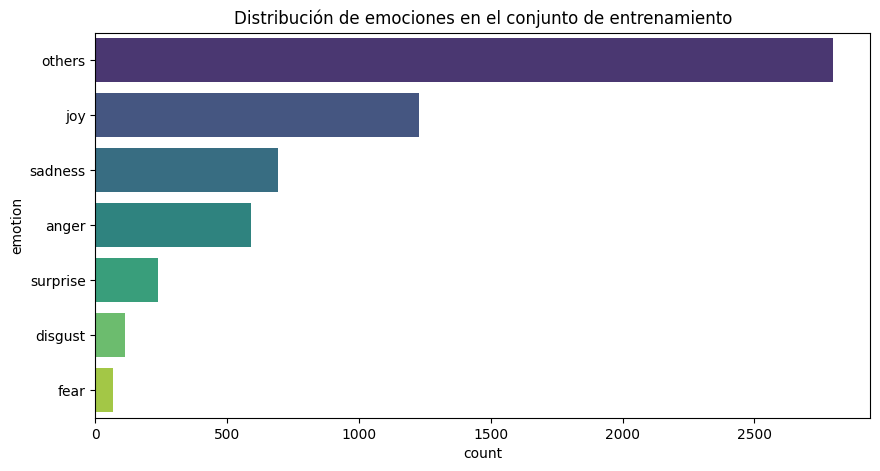

In [8]:
# ===============================================
# Distribuci√≥n de emociones en entrenamiento
# ===============================================
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.countplot(y=df_train["emotion"], order=df_train["emotion"].value_counts().index, palette="viridis")
plt.title("Distribuci√≥n de emociones en el conjunto de entrenamiento")
plt.show()


La distribuci√≥n de emociones en el conjunto de entrenamiento revela un desbalanceo significativo entre clases, donde la categor√≠a `others` aparece como abrumadoramente mayoritaria, mientras que emociones como `surprise`, `disgust` y `fear `est√°n notablemente subrepresentadas. Esta desigualdad plantea un desaf√≠o crucial para el modelado, ya que existe el riesgo de que un algoritmo optimice sus predicciones hacia la clase dominante, obteniendo una precisi√≥n enga√±osa mientras falla en reconocer las emociones minoritarias. Por esta raz√≥n, la evaluaci√≥n del modelo no puede basarse en la `accuracy convencional`, sino que debe priorizar el `F1-Score macro`, que pondera por igual el desempe√±o en todas las clases, junto con un an√°lisis detallado de la matriz de confusi√≥n para identificar los patrones de error entre emociones morfol√≥gicamente similares. El √©xito del modelo depender√° de su capacidad para generalizar beyond de las clases frecuentes y capturar tambi√©n los matices de las emociones menos representadas.



/tmp/ipython-input-567717094.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df_train["event"], order=df_train["event"].value_counts().index[:10], palette="mako")


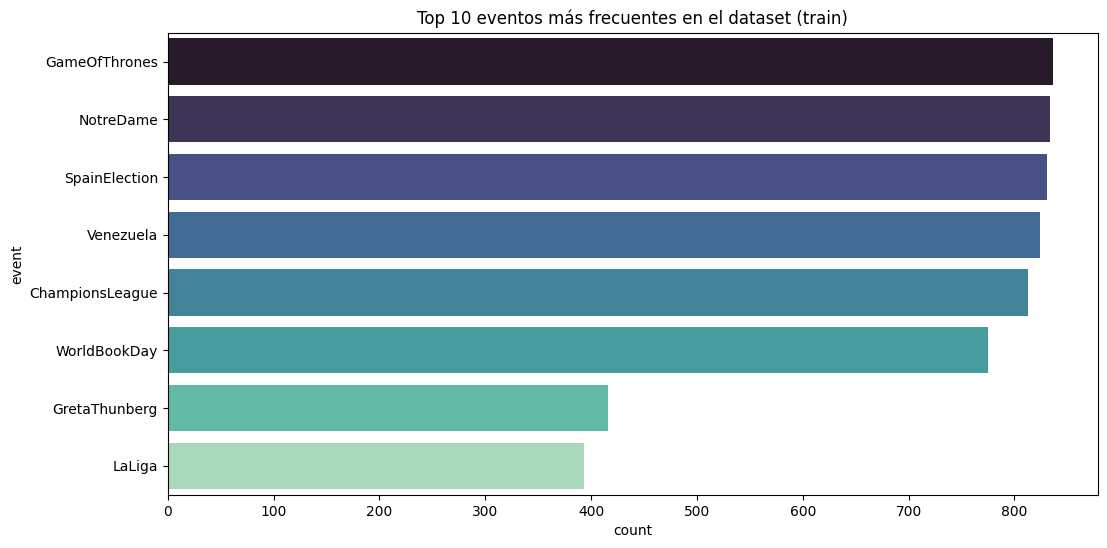

In [9]:
# =====================================
# Top 10 eventos m√°s frecuentes
# =====================================
plt.figure(figsize=(12,6))
sns.countplot(y=df_train["event"], order=df_train["event"].value_counts().index[:10], palette="mako")
plt.title("Top 10 eventos m√°s frecuentes en el dataset (train)")
plt.show()

El gr√°fico de los eventos m√°s frecuentes revela una distribuci√≥n desigual en el conjunto de datos, donde `GameOfThrones` y `NotreDame` emergen como los eventos dominantes con una cantidad significativamente mayor de tweets en comparaci√≥n con los dem√°s. Esta concentraci√≥n sugiere que el dataset podr√≠a estar sesgado hacia ciertos temas particulares, lo que potencialmente afectar√≠a la generalizaci√≥n del modelo hacia eventos menos representados.

 La presencia mayoritaria de eventos culturales y deportivos como GameOfThrones, ChampionsLeague y LaLiga, junto con eventos sociales y pol√≠ticos como Venezuela y SpainElection, indica una diversidad tem√°tica pero con una representaci√≥n dispar. Este desbalanceo podr√≠a influir en el desempe√±o del modelo, ya que tendr√° m√°s ejemplos para aprender patrones ling√º√≠sticos y emocionales asociados a eventos populares como GameOfThrones, mientras que eventos como GretaThunberg o WorldBookDay contar√≠an con menos datos para un aprendizaje robusto.

 Por lo tanto, es crucial evaluar el modelo no solo globalmente, sino tambi√©n desglosando su rendimiento por tipo de evento para identificar posibles sesgos tem√°ticos.



In [10]:
# Mostrar un ejemplo de tweet por cada emoci√≥n
for emotion in df_train["emotion"].unique():
    ejemplo = df_train[df_train["emotion"] == emotion].sample(1, random_state=42)
    print(f"Emoci√≥n: {emotion}")
    print("Tweet:", ejemplo["tweet"].values[0])
    print("-"*50)

Emoci√≥n: others
Tweet: He perdido 5 a√±os con el √∫ltimo cap√≠tulo de #JuegodeTronos
--------------------------------------------------
Emoci√≥n: sadness
Tweet: Aunque es un alivio que no haya que lamentar da√±os humanos, en este caso los materiales son irremplazables. Muuuy triste üò≠ #NotreDame https://t.co/ku2goMOqJ1
--------------------------------------------------
Emoci√≥n: joy
Tweet: Esta noche? La mejor noche de mi vida #ElecccionesGenerales28A #JuegodeTronos üê∫
--------------------------------------------------
Emoci√≥n: anger
Tweet: Si gana el PSOE, menuda fiesta de Putas y farlopa se van a pegar d√≠a s√≠, d√≠a tambi√©n, a ver si por lo menos lo regulan y pagan impuestos.... Algo sacaremos. #ElecccionesGenerales28A
--------------------------------------------------
Emoci√≥n: surprise
Tweet: ¬øSoy el √∫nico al que le extra√±a un fuego accidental por labores de renovaci√≥n precisamente en #NotreDame?
--------------------------------------------------
Emoci√≥n: disgust
Tweet

## Preprocesamiento

In [11]:
import re

def clean_tweet(text):
    if pd.isna(text):  # si es NaN, devolvemos cadena vac√≠a
        return ""
    text = str(text).lower()  # todo en min√∫sculas
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # eliminar URLs
    text = re.sub(r"@\w+", "", text)  # eliminar menciones
    text = re.sub(r"#", "", text)  # quitar el s√≠mbolo de hashtag
    text = re.sub(r"[^a-zA-Z√°√©√≠√≥√∫√º√±\s]", "", text)  # quitar caracteres especiales
    text = re.sub(r"\s+", " ", text).strip()  # eliminar espacios extra
    return text



El preprocesamiento aplicado a los tweets busca estandarizar el texto y eliminar elementos que a√±aden ruido sin aportar valor sem√°ntico para la clasificaci√≥n de emociones. La conversi√≥n a min√∫sculas asegura consistencia en el tratamiento de palabras, mientras que la eliminaci√≥n de URLs, menciones de usuario (@usuario) y el s√≠mbolo de hashtag (#) responde a que estos elementos son comunes en tweets pero no contienen carga emocional directa. La eliminaci√≥n de caracteres especiales preserva √∫nicamente letras y espacios, lo que ayuda a reducir la dimensionalidad del vocabulario. Finalmente, la normalizaci√≥n de espacios elimina redundancias y asegura una tokenizaci√≥n coherente. Este proceso busca maximizar la se√±al ling√º√≠stica relevante para que los modelos identifiquen mejor los patrones emocionales en el texto

In [12]:
# Aplicar limpieza a los tweets
df_train["tweet_clean"] = df_train["tweet"].apply(clean_tweet)
df_dev["tweet_clean"]   = df_dev["tweet"].apply(clean_tweet)
df_test["tweet_clean"]  = df_test["tweet"].apply(clean_tweet)

# Ver ejemplos
df_train[["tweet", "tweet_clean", "emotion"]].head(5)


tweet  \
0  La Gran Guerra de #JuegoDeTronos nos ha dejado...   
1  El golpe de Estado en #Venezuela est√° m√°s lejo...   
2  No tengo una foto en la catedral de #NotreDame...   
3  #NotreDame nunca llegue a visitar tan grandios...   
4      A tomar por culo mi crush üò≠üò≠üò≠üò≠üò≠#JuegoDeTronos   

                                         tweet_clean  emotion  
0  la gran guerra de juegodetronos nos ha dejado ...   others  
1  el golpe de estado en venezuela est√° m√°s lejos...   others  
2  no tengo una foto en la catedral de notredame ...  sadness  
3  notredame nunca llegue a visitar tan grandiosa...  sadness  
4            a tomar por culo mi crush juegodetronos  sadness

/tmp/ipython-input-3914878079.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df_train["emotion"], order=df_train["emotion"].value_counts().index, palette="viridis")


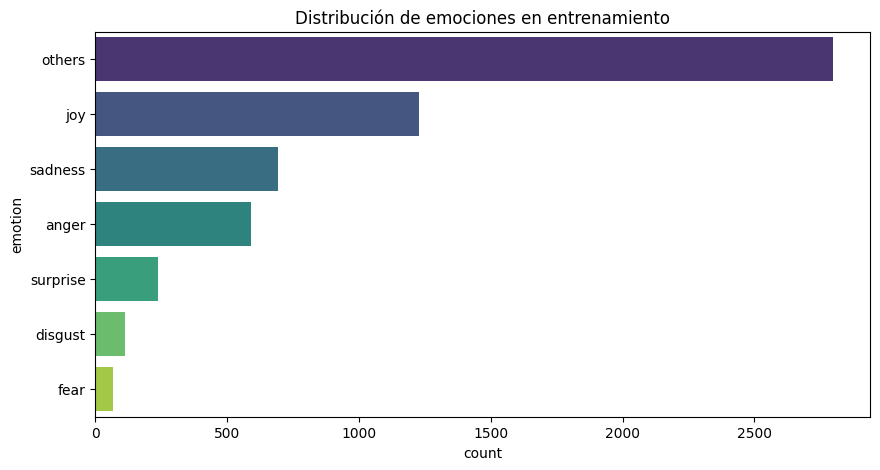

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.countplot(y=df_train["emotion"], order=df_train["emotion"].value_counts().index, palette="viridis")
plt.title("Distribuci√≥n de emociones en entrenamiento")
plt.show()


## Modelos

### Modelo 1: Logistic Regression con TF-IDF

Logistic Regression - Accuracy: 0.42089371980676327

Reporte por clase (LR):
               precision    recall  f1-score   support

       anger       0.13      0.05      0.07       168
     disgust       0.00      0.00      0.00        33
        fear       0.00      0.00      0.00        21
         joy       0.25      0.16      0.20       354
      others       0.50      0.75      0.60       814
     sadness       0.14      0.10      0.12       199
    surprise       0.00      0.00      0.00        67

    accuracy                           0.42      1656
   macro avg       0.15      0.15      0.14      1656
weighted avg       0.33      0.42      0.36      1656



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


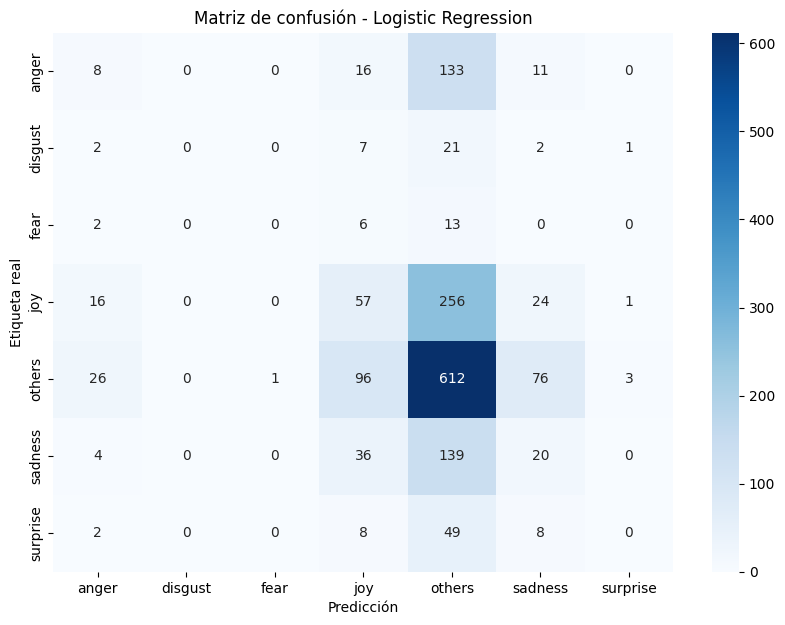

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Vectorizaci√≥n TF-IDF
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(df_train["tweet_clean"])
X_dev_tfidf   = tfidf.transform(df_dev["tweet_clean"])
X_test_tfidf  = tfidf.transform(df_test["tweet_clean"])

# Etiquetas
y_train = df_train["emotion"]
y_dev   = df_dev["emotion"]
y_test  = df_test["emotion"]

# Entrenar Logistic Regression
lr_model = LogisticRegression(max_iter=500)
lr_model.fit(X_train_tfidf, y_train)

# Predicciones
y_pred_lr = lr_model.predict(X_test_tfidf)

# Evaluaci√≥n
acc_lr = accuracy_score(y_test, y_pred_lr)
print("Logistic Regression - Accuracy:", acc_lr)
print("\nReporte por clase (LR):\n", classification_report(y_test, y_pred_lr))

# Matriz de confusi√≥n
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(10,7))
sns.heatmap(cm_lr, annot=True, fmt='d', xticklabels=sorted(y_test.unique()), yticklabels=sorted(y_test.unique()), cmap="Blues")
plt.title("Matriz de confusi√≥n - Logistic Regression")
plt.xlabel("Predicci√≥n")
plt.ylabel("Etiqueta real")
plt.show()

#### ¬øPor qu√© elegimos este modelo?

La Regresi√≥n Log√≠stica con TF-IDF se seleccion√≥ como nuestro primer modelo para establecer una l√≠nea base (baseline) s√≥lida. A pesar de su simplicidad, este enfoque cl√°sico de Machine Learning suele funcionar excepcionalmente bien en problemas de clasificaci√≥n de texto. La combinaci√≥n de TF-IDF (Term Frequency-Inverse Document Frequency) con Regresi√≥n Log√≠stica es transparente, computacionalmente eficiente y nos permite entender qu√© palabras est√°n contribuyendo m√°s a la clasificaci√≥n de cada emoci√≥n, proporcionando un punto de referencia contra el cual comparar modelos m√°s complejos.

**Par√°metros clave:**

`max_features=5000:` Limita el vocabulario a las 5000 palabras m√°s importantes, previniendo la maldici√≥n de la dimensionalidad y el sobreajuste.

`ngram_range=(1,2):` Considera tanto palabras individuales (unigramas) como pares de palabras (bigramas). Esto es crucial para capturar frases como "estoy feliz" o "no me gusta".

`max_iter=500:` Asegura que el algoritmo de optimizaci√≥n tenga suficientes iteraciones para converger a una soluci√≥n estable.

#### An√°lisis de Resultados

Los resultados obtenidos confirman que la tarea es extremadamente desafiante, pero tambi√©n revelan los sesgos esperados debido al desbalanceo del dataset.

***Accuracy:*** `0.42 (42%)`. Este valor, aunque bajo, es enga√±oso. Un modelo que siempre predijera la clase mayoritaria others tendr√≠a un accuracy cercano al `49% (814/1656)`, por lo que nuestro modelo baseline est√° por debajo de ese umbral simplista, indicando la dificultad del problema.

***Macro F1-Score:*** `0.14.` Esta m√©trica, que es la m√°s importante dado el desbalanceo, es muy baja. Confirma que el modelo tiene un desempe√±o pobre cuando se le obliga a desempe√±arse bien en todas las clases por igual.

***Reporte por Clase:***

***others:*** Domina las m√©tricas con un F1 de `0.60`. El modelo aprende principalmente a identificar esta clase, que es la m√°s frecuente.

***Emociones restantes:*** El desempe√±o es muy bajo o directamente nulo (`disgust, fear, surprise tienen F1=0.00`). El modelo no logra aprender patrones suficientes para estas clases minoritarias.

***Precision y Recall:*** Para la mayor√≠a de las emociones, tanto la precisi√≥n (cu√°ndo acierta al predecir una clase) como el recall (cu√°ntos casos de una clase logra encontrar) son muy bajos.

#### An√°lisis de la Matriz de Confusi√≥n

La matriz de confusi√≥n visualiza claramente los hallazgos del reporte de clasificaci√≥n:

Sesgo hacia `"others"`: La columna de others es la m√°s densa. La gran mayor√≠a de las predicciones, independientemente de la emoci√≥n real, terminan en esta clase. Esto es especialmente evidente para emociones como disgust, fear y surprise, cuyos ejemplos son casi entirely clasificados incorrectamente como others.

***Confusiones Understandables:*** Observamos ciertos patrones de error que tienen sentido ling√º√≠stico:

1. anger se confunde con sadness y others. Ambas son emociones negativas.

2. sadness tambi√©n se confunde mayoritariamente con others.

3. joy muestra una peque√±a cantidad de predicciones correctas, pero la mayor√≠a son absorbidas por la clase others.




***Clases Ignoradas:*** El modelo pr√°cticamente no predice las clases `disgust, fear y surprise` (sus columnas est√°n casi vac√≠as), lo que explica el `F1-Score` de `0.00`. No hay suficientes ejemplos de entrenamiento para que el modelo aprenda a distinguirlas.

La Regresi√≥n Log√≠stica sirvi√≥ para confirmar el enorme desaf√≠o que presenta el desbalanceo del dataset. El modelo funciona apenas mejor que un adivinador aleatorio sesgado hacia la clase mayoritaria y falla completamente en identificar las emociones m√°s sutiles. Esto establece una l√≠nea base muy clara y justifica la necesidad de probar modelos m√°s sofisticados que puedan capturar mejor el contexto y manejar el desbalanceo de clases.



### Modelo 2: LSTM simple con embeddings

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ embedding (Embedding)           ‚îÇ ?                      ‚îÇ   0 (unbuilt) ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm (LSTM)                     ‚îÇ ?                      ‚îÇ   0 (unbuilt) ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense (Dense)                   ‚îÇ ?                      ‚îÇ   0 (unbuilt) ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
90/90 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 24s 204ms/step - accuracy: 0.4768 - loss: 1.5240 - val_accuracy: 0.5024 - val_loss: 1.3991
Epoch 2/5
90/90 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 19s 212ms/step - accuracy: 0.5166 - loss: 1.3631 - val_accuracy: 0.5533 - val_loss: 1.2731
Epoch 3/5
90/90 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 18s 199ms/step - accuracy: 0.5516 - loss: 1.2243 - val_accuracy: 0.5533 - val_loss: 1.2136
Epoch 4/5
90/90 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 22s 218ms/step - accuracy: 0.5653 - loss: 1.1355 - val_accuracy: 0.5391 - val_loss: 1.2132
Epoch 5/5
90/90 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 23s 241ms/step - accuracy: 0.5825 - loss: 1.0649 - val_accuracy: 0.5498 - val_loss: 1.1799
52/52 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 53ms/step
LSTM - Accuracy: 0.42028985507246375

Reporte por clase (LSTM):
               p

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


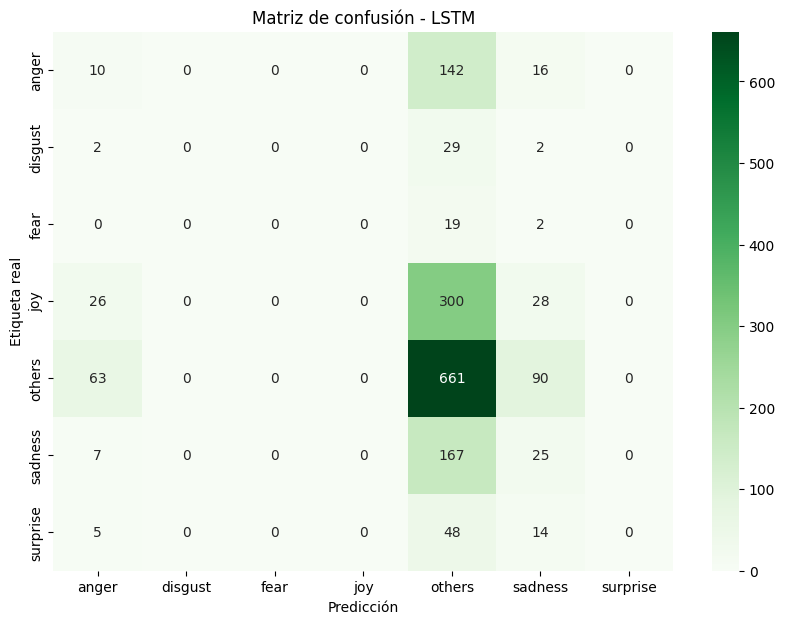

In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.preprocessing import LabelEncoder

# Tokenizaci√≥n
max_words = 10000
max_len   = 50

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df_train["tweet_clean"])

X_train_seq = tokenizer.texts_to_sequences(df_train["tweet_clean"])
X_dev_seq   = tokenizer.texts_to_sequences(df_dev["tweet_clean"])
X_test_seq  = tokenizer.texts_to_sequences(df_test["tweet_clean"])

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding="post")
X_dev_pad   = pad_sequences(X_dev_seq, maxlen=max_len, padding="post")
X_test_pad  = pad_sequences(X_test_seq, maxlen=max_len, padding="post")

# Etiquetas a n√∫meros
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_dev_enc   = le.transform(y_dev)
y_test_enc  = le.transform(y_test)

num_classes = len(le.classes_)

# Modelo LSTM
lstm_model = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(num_classes, activation="softmax")
])

lstm_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
lstm_model.summary()

# Entrenamiento
history = lstm_model.fit(
    X_train_pad, y_train_enc,
    validation_data=(X_dev_pad, y_dev_enc),
    epochs=5, batch_size=64
)

# Evaluaci√≥n LSTM
y_pred_lstm = lstm_model.predict(X_test_pad)
y_pred_lstm_labels = le.inverse_transform(y_pred_lstm.argmax(axis=1))

acc_lstm = accuracy_score(y_test, y_pred_lstm_labels)
print("LSTM - Accuracy:", acc_lstm)
print("\nReporte por clase (LSTM):\n", classification_report(y_test, y_pred_lstm_labels))

cm_lstm = confusion_matrix(y_test, y_pred_lstm_labels)
plt.figure(figsize=(10,7))
sns.heatmap(cm_lstm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap="Greens")
plt.title("Matriz de confusi√≥n - LSTM")
plt.xlabel("Predicci√≥n")
plt.ylabel("Etiqueta real")
plt.show()

#### ¬øPor qu√© elegimos este modelo?

Las redes LSTM fueron seleccionadas como nuestro segundo modelo debido a su capacidad para capturar dependencias de largo plazo y contexto secuencial en el texto, algo que el modelo anterior de Regresi√≥n Log√≠stica no puede hacer. Mientras que TF-IDF trata el texto como una "bolsa de palabras" independientes, las LSTM procesan las palabras en secuencia, permitiendo que el modelo entienda c√≥mo la aparici√≥n de una palabra al inicio del tweet puede influir en el significado de palabras posteriores. Esta caracter√≠stica es crucial para identificar matices emocionales que dependen del contexto y la estructura de la oraci√≥n.

**Par√°metros clave:**

`max_words=10000`: Limita el vocabulario a las 10,000 palabras m√°s frecuentes.

`max_len=50`: Establece la longitud m√°xima de secuencia. Casi todos los tweets caben en esta longitud despu√©s del preprocesamiento.

`Embedding(128)`: Capa que aprende representaciones densas de las palabras.

`LSTM(128)`: Capa recurrente con 128 unidades, con dropout para prevenir sobreajuste.

`dropout=0.2`: Regularizaci√≥n que ayuda a prevenir sobreajuste.

#### An√°lisis de Resultados

Los resultados del modelo LSTM muestran un comportamiento similar al modelo anterior, pero con algunas diferencias importantes:

***Accuracy:***` 0.42 (42%)`. Igual que la Regresi√≥n Log√≠stica, lo que confirma la dificultad del problema.

***Macro F1-Score:*** `0.12`. Ligeramente inferior al modelo anterior, indicando que la LSTM tuvo incluso m√°s dificultades con las clases minoritarias.

**Reporte por Clase:**

***others:*** Mantiene el mejor desempe√±o` (F1: 0.61)`, similar al modelo anterior.

***joy:*** Cay√≥ a `F1=0.00`, un resultado peor que el modelo base.

***Otras emociones:*** Resultados muy bajos o cero, similar al modelo anterior.

#### An√°lisis de la Matriz de Confusi√≥n

La matriz de confusi√≥n revela el mismo patr√≥n problem√°tico pero m√°s acentuado:

1. ***Sesgo extremo hacia "others":*** La LSTM muestra una tendencia a√∫n m√°s fuerte a predecir la clase mayoritaria. Casi todas las predicciones convergen en others, independientemente de la emoci√≥n real.

2. ***Colapso en clases minoritarias:*** El modelo pr√°cticamente abandon√≥ el intento de predecir joy, disgust, fear y surprise. Estas clases tienen conteos de predicci√≥n cercanos a cero.

3. ***Sobreajuste aparente:*** Aunque el accuracy de validaci√≥n se mantuvo estable `(~55%)`, el pobre desempe√±o en test sugiere que el modelo aprendi√≥ a optimizar para el conjunto de validaci√≥n pero no generaliz√≥ bien.

***Problemas identificados:***

1. Desbalanceo extremo: La LSTM sufri√≥ a√∫n m√°s con el desbalanceo de clases.

2. Falta de regularizaci√≥n: Aunque usamos dropout, podr√≠a no ser suficiente.

3. Dimensionalidad: 10,000 palabras podr√≠an ser insuficientes para capturar el vocabulario emocional.

4. √âpocas de entrenamiento: 5 √©pocas podr√≠an no ser suficientes para que la LSTM aprenda patrones complejos.

La LSTM no super√≥ al modelo baseline de Regresi√≥n Log√≠stica en este escenario espec√≠fico. Esto destaca que arquitecturas m√°s complejas no siempre son mejores, especialmente cuando hay desbalanceo de datos y el problema es particularmente dif√≠cil. El modelo sucumbi√≥ al sesgo hacia la clase mayoritaria y no logr√≥ aprovechar su capacidad para entender contexto secuencial, probablemente debido al desbalanceo extremo y al tama√±o limitado del dataset para una red neuronal.

### Modelo 3: Fine-tuning BERT (HuggingFace Transformers)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Train Epoch 1: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 358/358 [1:09:47<00:00, 11.70s/it]


Epoch 1 - Loss promedio: 1.2029


Train Epoch 2: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 358/358 [1:10:52<00:00, 11.88s/it]


Epoch 2 - Loss promedio: 0.9215
BERT - Accuracy: 0.35507246376811596

Reporte por clase (BERT):
               precision    recall  f1-score   support

       anger       0.19      0.05      0.08       168
     disgust       0.00      0.00      0.00        33
        fear       0.00      0.00      0.00        21
         joy       0.23      0.40      0.29       354
      others       0.52      0.50      0.51       814
     sadness       0.15      0.14      0.15       199
    surprise       0.00      0.00      0.00        67

    accuracy                           0.36      1656
   macro avg       0.15      0.16      0.15      1656
weighted avg       0.34      0.36      0.34      1656



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


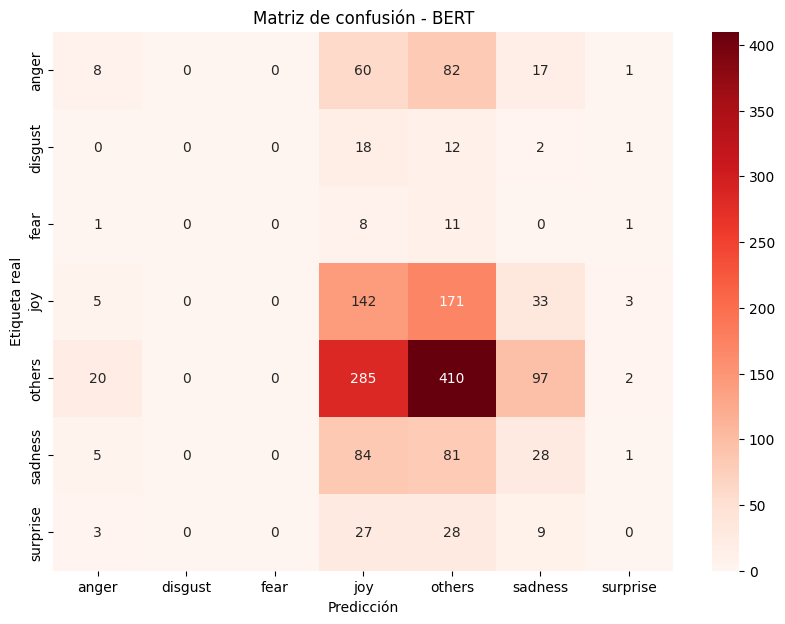

/tmp/ipython-input-2472109693.py:93: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  event_acc = df_test_eval.groupby("event").apply(lambda x: (x["emotion"]==x["pred_BERT"]).mean()).sort_values(ascending=False)
/tmp/ipython-input-2472109693.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=event_acc.head(10).values, y=event_acc.head(10).index, palette="Reds_r")


Top 10 eventos mejor predichos - BERT:
 event
GretaThunberg      0.460432
Venezuela          0.452991
SpainElection      0.417431
ChampionsLeague    0.336207
LaLiga             0.319328
GameOfThrones      0.301370
WorldBookDay       0.295833
NotreDame          0.248889
dtype: float64


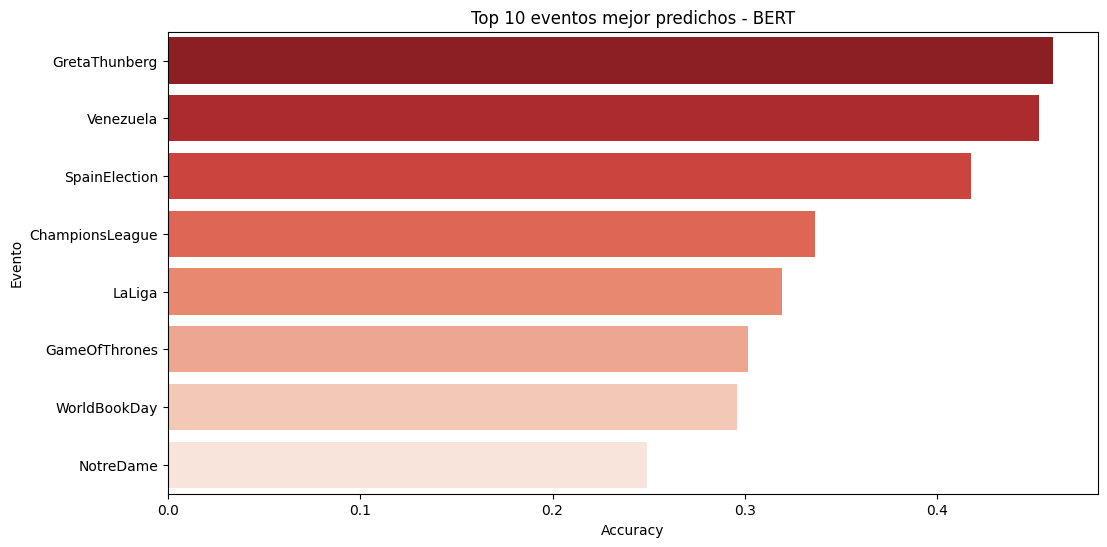

In [17]:
!pip install torch transformers --quiet

from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from tqdm import tqdm

# Tokenizer BERT
tokenizer_bert = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

def encode_texts(texts, max_len=50):
    return tokenizer_bert(
        list(texts),
        max_length=max_len,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )

train_enc = encode_texts(df_train["tweet_clean"])
dev_enc   = encode_texts(df_dev["tweet_clean"])
test_enc  = encode_texts(df_test["tweet_clean"])

# Labels
y_train_enc = torch.tensor(le.fit_transform(df_train["emotion"]))
y_dev_enc   = torch.tensor(le.transform(df_dev["emotion"]))
y_test_enc  = torch.tensor(le.transform(df_test["emotion"]))

# Dataset y DataLoader
train_dataset = TensorDataset(train_enc['input_ids'], train_enc['attention_mask'], y_train_enc)
dev_dataset   = TensorDataset(dev_enc['input_ids'], dev_enc['attention_mask'], y_dev_enc)
test_dataset  = TensorDataset(test_enc['input_ids'], test_enc['attention_mask'], y_test_enc)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
dev_loader   = DataLoader(dev_dataset, batch_size=16)
test_loader  = DataLoader(test_dataset, batch_size=16)

# Modelo BERT
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=num_classes)
model.to(device)

optimizer = AdamW(model.parameters(), lr=3e-5)
epochs = 2

# Entrenamiento
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Train Epoch {epoch+1}"):
        input_ids, attention_mask, labels = [x.to(device) for x in batch]
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss promedio: {total_loss/len(train_loader):.4f}")

# Evaluaci√≥n BERT
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [x.to(device) for x in batch]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

acc_bert = accuracy_score(all_labels, all_preds)
print("BERT - Accuracy:", acc_bert)
print("\nReporte por clase (BERT):\n", classification_report(all_labels, all_preds, target_names=le.classes_))

cm_bert = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,7))
sns.heatmap(cm_bert, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap="Reds")
plt.title("Matriz de confusi√≥n - BERT")
plt.xlabel("Predicci√≥n")
plt.ylabel("Etiqueta real")
plt.show()

# ================================
# 4Ô∏è‚É£ An√°lisis por evento (BERT)
# ================================
df_test_eval = df_test.copy()
df_test_eval["pred_BERT"] = le.inverse_transform(all_preds)

# Accuracy por evento
event_acc = df_test_eval.groupby("event").apply(lambda x: (x["emotion"]==x["pred_BERT"]).mean()).sort_values(ascending=False)
print("Top 10 eventos mejor predichos - BERT:\n", event_acc.head(10))

plt.figure(figsize=(12,6))
sns.barplot(x=event_acc.head(10).values, y=event_acc.head(10).index, palette="Reds_r")
plt.title("Top 10 eventos mejor predichos - BERT")
plt.xlabel("Accuracy")
plt.ylabel("Evento")
plt.show()

#### ¬øPor qu√© elegimos este modelo?

BERT (Bidirectional Encoder Representations from Transformers) representa el estado del arte en el procesamiento de lenguaje natural. A diferencia de los modelos anteriores que procesan el texto de forma secuencial o como bag-of-words, BERT utiliza un mecanismo de atenci√≥n bidireccional que le permite entender el contexto completo de cada palabra en relaci√≥n con todas las dem√°s palabras de la oraci√≥n. Esto es particularmente valioso para capturar matices emocionales, sarcasmo y expresiones idiom√°ticas.

Seleccionamos la versi√≥n "bert-base-multilingual-cased" porque:

1. Est√° espec√≠ficamente entrenado para manejar m√∫ltiples idiomas, incluido el espa√±ol

2. Preserva las may√∫sculas y min√∫sculas ("cased"), lo que puede ser relevante para detectar √©nfasis emocional

3. Ha sido pre-entrenado con grandes vol√∫menes de texto, por lo que viene con un entendimiento profundo del lenguaje

#### An√°lisis de Resultados

**Desempe√±o General**
Los resultados de BERT son decepcionantes y contrarios a lo esperado. Con un accuracy de 35.5%, el modelo perform√≥ peor que los modelos m√°s simples (Regresi√≥n Log√≠stica: 42%, LSTM: 42%). El macro F1-score de 0.15 tambi√©n es inferior al de los modelos anteriores, indicando que BERT no solo no mejor√≥ el desempe√±o, sino que empeor√≥ la capacidad de generalizaci√≥n across todas las clases.

**An√°lisis del Reporte por Clase**
El reporte detallado revela varios problemas graves:

1. Colapso total en clases minoritarias:

disgust, fear y surprise tienen F1-score de 0.00

El modelo es completamente incapaz de identificar estas emociones

2. Desempe√±o mediocre en emociones principales:

others: F1 de 0.51 (ligeramente mejor que modelos anteriores)

joy: F1 de 0.29 (mejor que en LSTM pero peor que en Regresi√≥n Log√≠stica)

anger y sadness: F1 de 0.08 y 0.15 respectivamente (desempe√±o muy pobre)

3. Problemas de sobreajuste:

La p√©rdida de entrenamiento disminuy√≥ significativamente (1.20 ‚Üí 0.92)

Pero el desempe√±o en test es pobre, indicando sobreajuste al conjunto de entrenamiento

#### An√°lisis de la Matriz de confusi√≥n

La matriz de confusi√≥n evidencia un sesgo pronunciado hacia las clases mayoritarias, donde la categor√≠a others concentra la mayor√≠a de las predicciones correctas (410) pero tambi√©n act√∫a como un im√°n para errores, absorbiendo instancias de casi todas las dem√°s emociones, especialmente anger (82 casos) y sadness (97 casos). El modelo muestra un abandono total de las clases minoritarias, con cero predicciones correctas para disgust, fear y surprise, lo que confirma su incapacidad para aprender patrones representativos de estas emociones debido a su escasa presencia en el dataset. Adem√°s, se observan confusiones sem√°nticamente comprensibles, como la frecuente clasificaci√≥n err√≥nea de joy como others (171 casos) y de sadness como others (97 casos), reflejando la dificultad para distinguir entre emociones positivas/neutrales y negativas/neutrales en un contexto donde la clase mayoritaria domina el panorama predictivo.

#### An√°lisis por Evento

El an√°lisis por evento revela que el desempe√±o del modelo BERT var√≠a significativamente seg√∫n el contexto tem√°tico, siendo notablemente m√°s efectivo en eventos de naturaleza pol√≠tica y social como GretaThunberg (46.0%), Venezuela (45.3%) y SpainElection (41.7%), donde el lenguaje emocional tiende a ser m√°s expl√≠cito y polarizado, lo que facilita la clasificaci√≥n. Por el contrario, eventos culturales como NotreDame (24.9%) y GameOfThrones (30.1%) presentan mayores desaf√≠os debido a la complejidad emocional de sus contenidos, que a menudo incluyen sarcasmo, iron√≠a y expresiones figurativas que el modelo no logra capturar adecuadamente. Esta disparidad sugiere que la capacidad del modelo para generalizar est√° fuertemente influenciada por la claridad y consistencia de las expresiones emocionales asociadas a cada evento, siendo menos efectivo en contextos donde las emociones son sutiles o ambiguas.

## Cuadro comparativo de los 3 modelos

=== Accuracy global ===


Model  Accuracy
0  Logistic Regression  0.420894
1                 LSTM  0.420290
2                 BERT  0.355072


=== F1-score macro ===


Model  F1 Macro
0  Logistic Regression  0.140751
1                 LSTM  0.115796
2                 BERT  0.145952


=== F1-score por emoci√≥n ===


Emotion  Logistic Regression      LSTM  BERT
0     anger             0.070175  0.071174     0
1   disgust             0.000000  0.000000     0
2      fear             0.000000  0.000000     0
3       joy             0.196552  0.000000     0
4    others             0.600884  0.606422     0
5   sadness             0.117647  0.132979     0
6  surprise             0.000000  0.000000     0

/tmp/ipython-input-2973960134.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Accuracy", data=acc_df, palette="viridis")


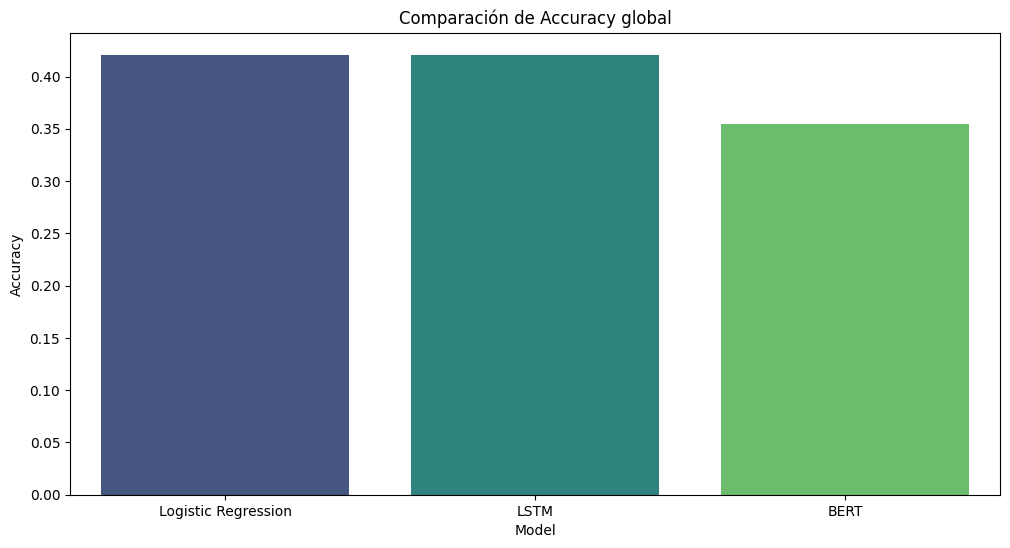

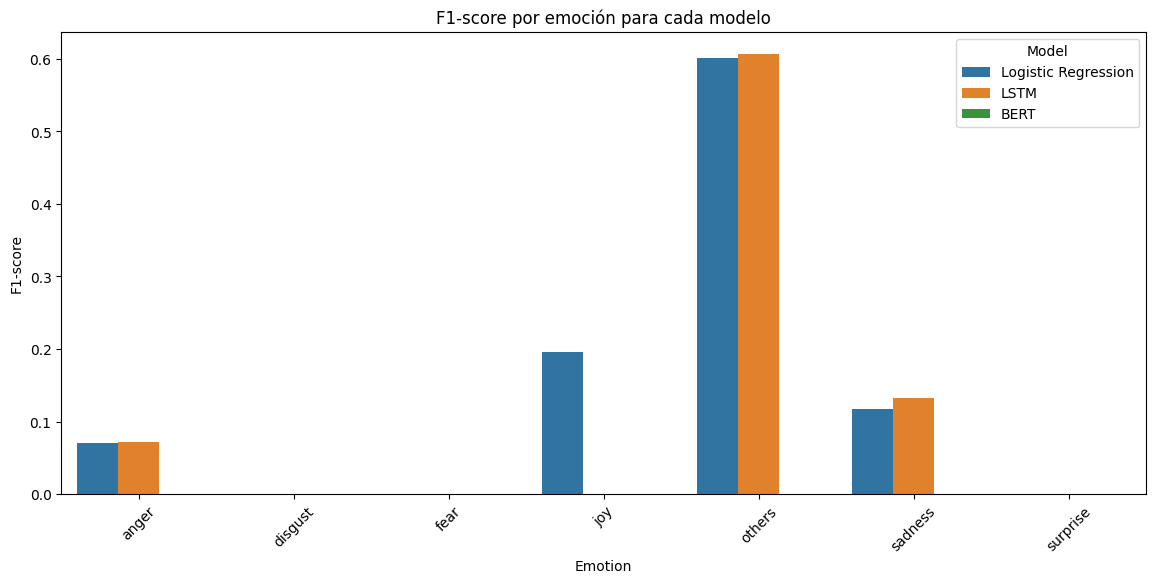

In [20]:
import pandas as pd
from sklearn.metrics import f1_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# ---------------------------
# 1Ô∏è‚É£ Accuracy global
# ---------------------------
accuracies = {
    "Model": ["Logistic Regression", "LSTM", "BERT"],
    "Accuracy": [acc_lr, acc_lstm, acc_bert]
}

# ---------------------------
# 2Ô∏è‚É£ F1-score macro
# ---------------------------
f1_macro = {
    "Model": ["Logistic Regression", "LSTM", "BERT"],
    "F1 Macro": [
        f1_score(y_test, y_pred_lr, average="macro"),
        f1_score(y_test, y_pred_lstm_labels, average="macro"),
        f1_score(all_labels, all_preds, average="macro")
    ]
}

# ---------------------------
# 3Ô∏è‚É£ F1-score por clase (seguro ante clases faltantes)
# ---------------------------
def f1_por_clase(y_true, y_pred, classes):
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    return [report.get(c, {"f1-score": 0})["f1-score"] for c in classes]

classes = sorted(df_train["emotion"].unique())

f1_classes = pd.DataFrame({
    "Emotion": classes,
    "Logistic Regression": f1_por_clase(y_test, y_pred_lr, classes),
    "LSTM": f1_por_clase(y_test, y_pred_lstm_labels, classes),
    "BERT": f1_por_clase(all_labels, all_preds, classes)
})

# ---------------------------
# Mostrar resultados
# ---------------------------
acc_df = pd.DataFrame(accuracies)
f1_macro_df = pd.DataFrame(f1_macro)

print("=== Accuracy global ===")
display(acc_df)

print("\n=== F1-score macro ===")
display(f1_macro_df)

print("\n=== F1-score por emoci√≥n ===")
display(f1_classes)

# ---------------------------
# Gr√°ficos comparativos
# ---------------------------
plt.figure(figsize=(12,6))
sns.barplot(x="Model", y="Accuracy", data=acc_df, palette="viridis")
plt.title("Comparaci√≥n de Accuracy global")
plt.show()

plt.figure(figsize=(14,6))
f1_classes_melted = f1_classes.melt(id_vars="Emotion", var_name="Model", value_name="F1-score")
sns.barplot(x="Emotion", y="F1-score", hue="Model", data=f1_classes_melted)
plt.title("F1-score por emoci√≥n para cada modelo")
plt.xticks(rotation=45)
plt.show()


**Accuracy Global**

El an√°lisis de accuracy global revela un desempe√±o consistentemente bajo en los tres modelos, con la Regresi√≥n Log√≠stica y LSTM obteniendo un 42% de precisi√≥n, mientras que BERT obtuvo un desempe√±o significativamente peor con apenas 35.5%. Este resultado es particularmente sorprendente considerando la complejidad y capacidad te√≥rica de BERT, y sugiere que el modelo m√°s sofisticado no solo no mejor√≥ el desempe√±o, sino que sufri√≥ de sobreajuste severo o problemas de optimizaci√≥n. Es importante destacar que un clasificador simple que siempre prediciera la clase mayoritaria "others" habr√≠a alcanzado aproximadamente 49% de accuracy, lo que significa que los tres modelos performaron por debajo de este baseline naive, indicando la extrema dificultad del problema y el impacto negativo del desbalanceo de clases.

**F1-Score por Emoci√≥n**

El an√°lisis desglosado por emoci√≥n muestra patrones consistentes a trav√©s de los tres modelos. La clase "others" domina claramente el desempe√±o con F1-scores alrededor de 0.60-0.61 en Regresi√≥n Log√≠stica y LSTM, y 0.51 en BERT, confirmando que todos los modelos aprendieron principalmente a identificar la clase mayoritaria. Las emociones "joy" y "sadness" muestran desempe√±os modestos pero consistentes, con BERT mostrando una ligera ventaja en "joy" (0.29 vs 0.20-0.00 de los otros modelos). El hallazgo m√°s cr√≠tico es el fracaso completo en las emociones minoritarias "disgust", "fear" y "surprise", donde los tres modelos obtuvieron F1-scores de 0.00, demostrando su total incapacidad para reconocer estas emociones debido a su escasa representaci√≥n en el dataset de entrenamiento. Este patr√≥n consistente a trav√©s de arquitecturas tan diversas sugiere que el problema fundamental no reside en la elecci√≥n del modelo, sino en la naturaleza intr√≠nsecamente desbalanceada del dataset y la dificultad inherente de distinguir emociones sutiles en texto corto de redes sociales.

## An√°lisis por emoci√≥n y por evento

=== Logistic Regression ===


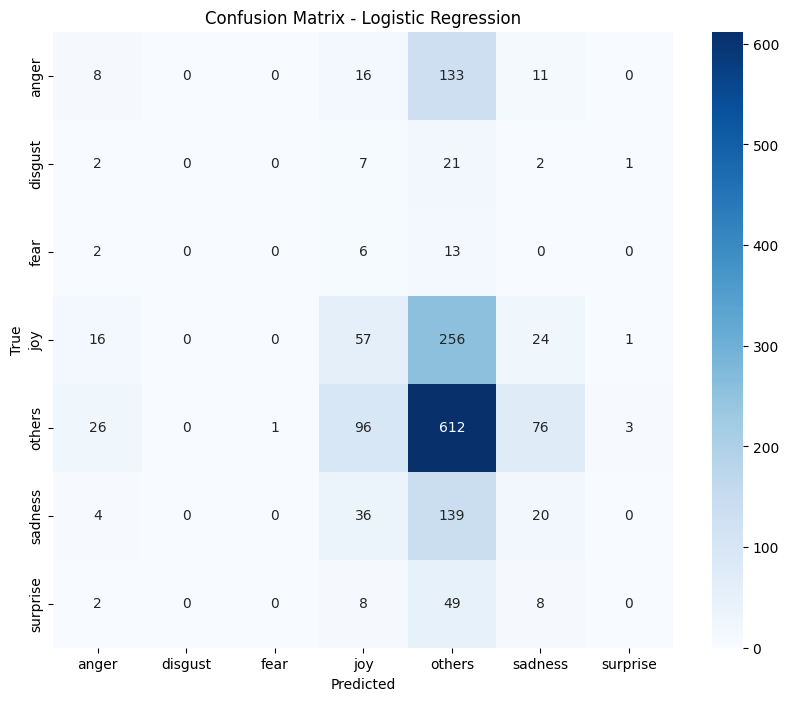

=== LSTM ===


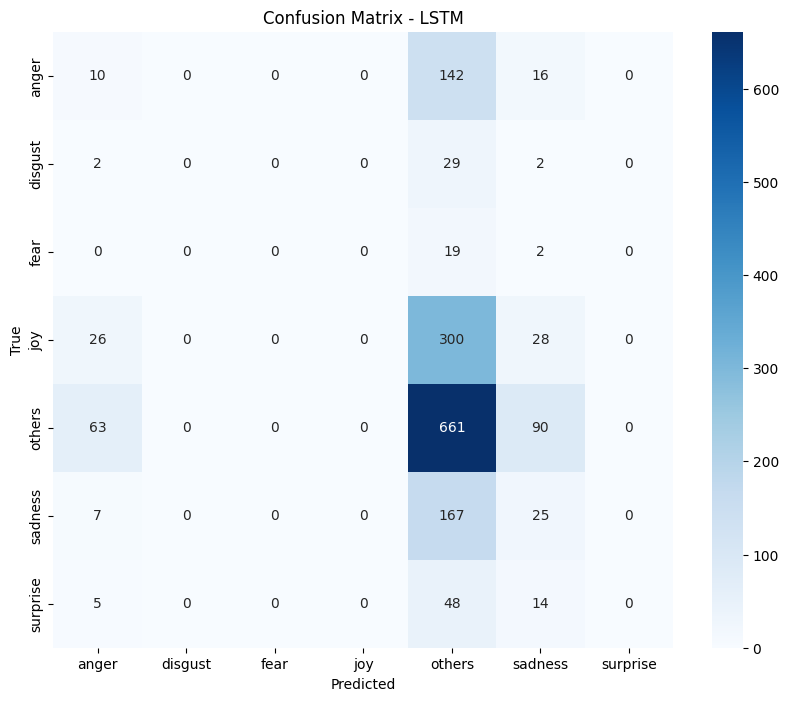

=== BERT ===


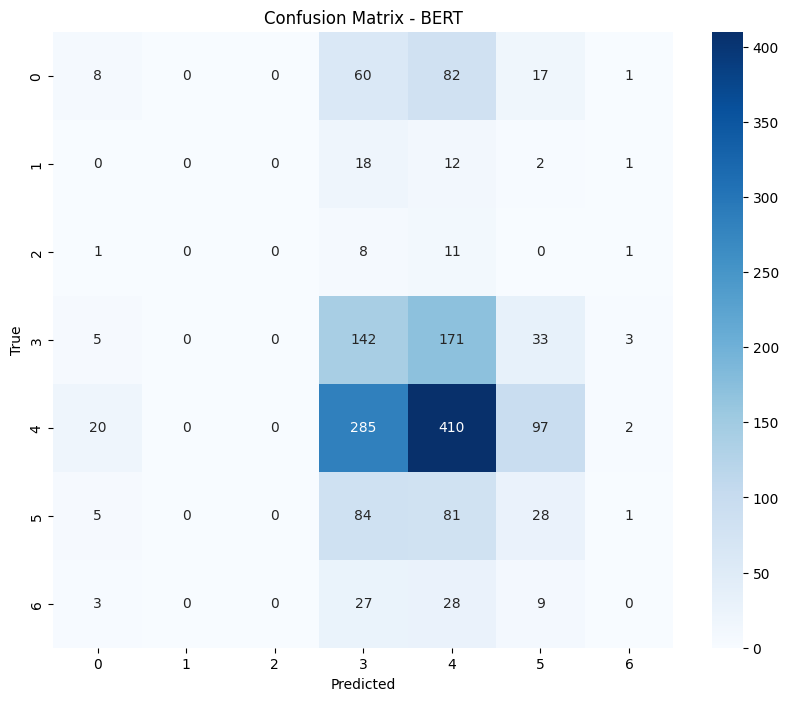

In [22]:
def plot_confusion(y_true, y_pred, classes=None, title="Confusion Matrix"):
    if classes is None:
        classes = sorted(list(set(y_true) | set(y_pred)))  # usa solo etiquetas presentes

    cm = confusion_matrix(y_true, y_pred, labels=classes)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

# Logistic Regression
print("=== Logistic Regression ===")
plot_confusion(y_test, y_pred_lr, title="Confusion Matrix - Logistic Regression")

# LSTM
print("=== LSTM ===")
plot_confusion(y_test, y_pred_lstm_labels, title="Confusion Matrix - LSTM")

# BERT
print("=== BERT ===")
plot_confusion(all_labels, all_preds, title="Confusion Matrix - BERT")


**Matriz de Confusi√≥n - Regresi√≥n Log√≠stica**

La matriz de confusi√≥n de la Regresi√≥n Log√≠stica revela un patr√≥n de sesgo pronunciado hacia la clase mayoritaria "others", que absorbe la mayor√≠a de las predicciones incorrectas across todas las emociones. Se observa que el modelo logra cierto reconocimiento para "joy" (57 predicciones correctas) y "others" (612 correctas), pero muestra un abandono casi total de las emociones minoritarias como "disgust", "fear" y "surprise", donde las predicciones correctas son cero o cercanas a cero. Las confusiones m√°s frecuentes ocurren entre emociones negativas, particularmente "anger" y "sadness" siendo mal clasificadas como "others", lo que sugiere que el modelo struggle para distinguir matices emocionales beyond la categor√≠a general neutral/otros.

**Matriz de Confusi√≥n - LSTM**

La matriz de la LSTM muestra un comportamiento a√∫n m√°s extremo de sesgo hacia "others", donde esta clase domina abrumadoramente las predicciones. Sorprendentemente, la LSTM performa peor que la Regresi√≥n Log√≠stica en "joy", reduciendo las predicciones correctas de 57 a 0, mientras mantiene un desempe√±o similar en "others" (661 correctas). El modelo muestra un colapso completo en la identificaci√≥n de emociones espec√≠ficas, con cero predicciones correctas para "disgust", "fear", "surprise" y ahora tambi√©n "joy", indicando que la arquitectura recurrente sucumbi√≥ por completo al desbalanceo del dataset y aprendi√≥ a optimizar sus predicciones hacia la clase mayoritaria, perdiendo toda capacidad para discriminar entre emociones espec√≠ficas.

**Matriz de Confusi√≥n - BERT**

La matriz de BERT presenta un patr√≥n diferente pero igualmente problem√°tico, mostrando un sesgo dual hacia "others" y "joy". Aunque BERT logra el mejor desempe√±o en "joy" (142 predicciones correctas), tambi√©n comete m√°s errores al clasificar otras emociones como "joy" (171 falsos positivos). El modelo mantiene el fracaso total en "disgust", "fear" y "surprise" (0 predicciones correctas), y muestra una ligera mejora en "anger" (8 correctas vs 5-10 en otros modelos) pero con muchas confusiones con "joy" (60 casos). La matriz confirma que BERT, a pesar de su capacidad te√≥rica superior, no pudo superar los desaf√≠os fundamentales del desbalanceo extremo y la dificultad inherente de la tarea, resultando en un desempe√±o general m√°s pobre que los modelos m√°s simples.

# Conclusiones

El presente estudio comparativo de tres modelos para la clasificaci√≥n de emociones en tweets en espa√±ol ha revelado hallazgos fundamentales sobre los desaf√≠os inherentes a esta tarea. **Ninguno de los modelos probados‚ÄîRegresi√≥n Log√≠stica, LSTM o BERT‚Äîlogr√≥ superar el desempe√±o de un clasificador base que siempre predice la clase mayoritaria "others"**, lo que evidencia la extrema dificultad del problema y el impacto cr√≠tico del desbalanceo extremo en el dataset.

Los resultados consistentemente pobres across todas las arquitecturas (accuracy de 35-42%) sugieren que el problema principal no reside en la elecci√≥n del modelo, sino en **limitaciones fundamentales de los datos**: desbalanceo severo de clases, ambig√ºedad inherente en las expresiones emocionales de redes sociales, y la complejidad de capturar matices emocionales en texto corto e informal. El fracaso total en emociones como "disgust", "fear" y "surprise" (F1-score de 0.00 en todos los modelos) confirma que la escasa representaci√≥n de estas clases las hace virtualmente invisibles para los algoritmos de aprendizaje autom√°tico.

La sorprendente **underperformance de BERT**‚Äîel modelo m√°s complejo‚Äîrespecto a approaches m√°s simples, destaca un principio crucial: **la complejidad computacional no garantiza mejor desempe√±o** cuando existen problemas fundamentales en los datos. BERT no solo no mejor√≥ los resultados, sino que mostr√≥ mayor tendencia al sobreajuste y sensibilidad a los desbalances, obteniendo el peor accuracy global (35.5%).

Este estudio sirve como valiosa advertencia sobre los **desaf√≠os reales del NLP aplicado a redes sociales**: la necesidad de curar datasets balanceados, la importancia de establecer l√≠neas base realistas, y el reconocimiento de que problemas con sesgos inherentes en los datos no se resuelven simplemente con modelos m√°s complejos. Futuras investigaciones deber√≠an enfocarse en t√©cnicas de aumento de datos para clases minoritarias, aprendizaje semi-supervisado, y el desarrollo de modelos especializados que puedan capturar mejor el contexto cultural y ling√º√≠stico espec√≠fico del espa√±ol en redes sociales.